# Example: Prostate Cancer

The data come from a study by Stamey et al. (1989). They
examined the correlation between the level of prostate-specific antigen and
a number of clinical measures in men who were about to receive a radical
prostatectomy.

The variables are:
    
   * lcavol: log cancer volume
   * lweight: log prostate weight
   * age
   * lbph: log of the amount of benign prostatic hyperplasia
   * svi: seminal vesicle invasion (binary)
   * lcp: log of capsular penetration
   * gleason: Gleason score (ordered categorical) 
   * pgg45: percent of Gleason scores 4 or 5
   * lpsa: level of prostate-specific antigen (response)
   
### Python Implementation

This section is about the python implementation of the example given in the book. I tried to produce results that mimic the ones presented in the book as close as possible.

In [1]:
# import some necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sys
import scipy.stats
from matplotlib.ticker import FormatStrFormatter
from ml_datasets.esl import ProstateCancer

First, we load the data using `ml_datasets` package.

In [2]:
prostate_cancer = ProstateCancer()

In [3]:
df = prostate_cancer.load()

Retrieving ESL-Prostate_Cancer dataset...
C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.data available locally, skip downloading
C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.info.txt available locally, skip downloading


This dataset contains some info as follows:

In [4]:
print(prostate_cancer.info)

Prostate data info

Predictors (columns 1--8)

lcavol
lweight
age
lbph
svi
lcp
gleason
pgg45

outcome (column 9)

lpsa

train/test indicator (column 10)

This last column indicates which 67 observations were used as the 
"training set" and which 30 as the test set, as described on page 48
in the book.

There was an error in these data in the first edition of this
book. Subject 32 had a value of 6.1 for lweight, which translates to a
449 gm prostate! The correct value is 44.9 gm. We are grateful to
Prof. Stephen W. Link for alerting us to this error.

The features must first be scaled to have mean zero and  variance 96 (=n)
before the analyses in Tables 3.1 and beyond.  That is, if x is the  96 by 8 matrix
of features, we compute xp <- scale(x,TRUE,TRUE)




### Scatter-plot Matrix
The book shows the scatterplot matrix of the dataset in Figure 1.1 of Chapter 1. It shows every pairwise plot between the variables.

The following method is used to format the scatterplot matrix to look similar to the one in the book.

In [5]:
def format_scatter_plot(axes):
    # iterate through all the subplots
    for i, label in enumerate(column_reordered):
        for j, _ in enumerate(column_reordered):
            if i == j:
                # clear the subplot diagonal and annotate it with label
                axes[i,i].clear()
                axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=15)
            ax = axes[i, j]
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.yaxis.label.set_rotation(90)

            if ax.is_first_col():
                ax.yaxis.set_ticks_position('left')
                plt.sca(ax)
                plt.yticks(rotation=90)

            if ax.is_last_col():
                ax.yaxis.set_ticks_position('right')
                plt.sca(ax)
                plt.yticks(rotation=90)
                if ax.is_last_row():
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            if ax.is_first_row():
                ax.xaxis.set_ticks_position('top')

            if ax.is_last_row():
                ax.xaxis.set_ticks_position('bottom')
                plt.sca(ax)
                plt.xticks(rotation=0)

    for i, j in zip(range(len(column_reordered)), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

I use `pandas` plotting function to get the scatterplot matrix

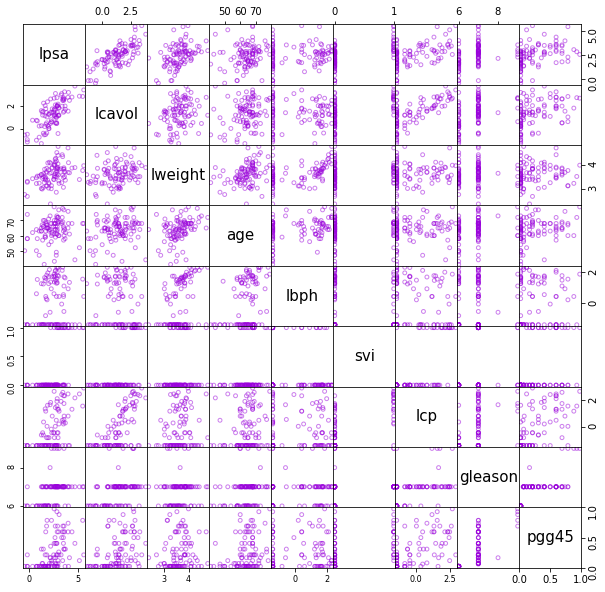

In [6]:
# reordering columns to have identical result as the one in the book
column_reordered = ['lpsa'] + prostate_cancer.meta[:-1]

# plot scatter matrix
axes = pd.plotting.scatter_matrix(df[column_reordered], figsize=(10, 10), marker='o', facecolors="none", edgecolors='#9A03DB', s=15)

# plot formatting
format_scatter_plot(axes)
plt.show()

We see that `svi` and `gleason` are binary and ordered categorical variables, respectively.

The plot also shows that both `lcavol` and `lcp` show a strong linear relationship with the response `lpsa` and with each other.

### Linear Model Fitting
First, we extract the input `x` and output `y` data frames from the original full dataframe along with the `train_test` indicator.

In [17]:
# extract input and output dataframe
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

#### Scaling
From the info of the dataset, we are required to scale the features to have zero mean and unit variance.
There are some libraries that can do that for us. However, here, I just want to write my own scaling method: 

In [18]:
def scale(x):
    mean = x.values.mean(axis=0, keepdims=True)
    stdev = x.values.std(axis=0, keepdims=True, ddof=0)
    return np.divide(np.subtract(x, mean), stdev)

In [19]:
df_x = df_x.apply(lambda x: scale(x))
df_x.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.645861,-2.016634,-1.872101,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
1,-1.999313,-0.725759,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
2,-1.587021,-2.200154,1.368234,-1.030029,-0.525657,-0.867655,0.344407,-0.156155
3,-2.178174,-0.812191,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
4,-0.510513,-0.461218,-0.251933,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957


In [20]:
df_y.head()

0   -0.430783
1   -0.162519
2   -0.162519
3   -0.162519
4    0.371564
Name: lpsa, dtype: float64

#### Correlation of Predictors

The first result shown in the book is the correlation table of predictors. I use `Pearson` correlation provided by the `pandas` lib.
Necessary formatting and dropping are done to have identical result as the one shown in TABLE 3.1 in the book.

In [21]:
corr_table = df_x[train_test=='T'].corr(method='pearson').drop('lcavol').drop('pgg45', axis=1).apply(lambda x: x.map('{:.3f}'.format))
corr_table.where(np.tril(np.ones(corr_table.shape)).astype(np.bool)).replace(np.nan, '', regex=True)

,lcavol,lweight,age,lbph,svi,lcp,gleason
lweight,0.300,,,,,,
age,0.286,0.317,,,,,
lbph,0.063,0.437,0.287,,,,
svi,0.593,0.181,0.129,-0.139,,,
lcp,0.692,0.157,0.173,-0.089,0.671,,
gleason,0.426,0.024,0.366,0.033,0.307,0.476,
pgg45,0.483,0.074,0.276,-0.030,0.481,0.663,0.757


#### Least Squares Regression

Here, I tried to build a class for least squares regression. This class contains several methods:

   * `fit`: to fit the model using the least squares algorithm (similar to the one in Chapter 2). In here, we'll obtain $\hat\beta$.
   * `_check_condition`: to check the condition of the $\mathbf{X}^\top\mathbf{X}$ matrix. It's necessary to make sure that the matrix is invertible.
   * `calculate_z`: to calculate the $Z$-score using the following equations:
   
   $$\begin{aligned}z_j &= \frac{\hat\beta_j}{\hat\sigma\sqrt{v_j}}\\
   \hat\sigma^2 &= \frac{1}{N - p - 1} \sum_{i=1}^{N}(y_i - \hat y_i)^2
   \end{aligned}$$
   * `predict`: do prediction using the the following equation:
   $$\hat{\mathbf{Y}} = \mathbf{X}\hat\beta$$
   * `calculate_f`: calculate the $F$ statistic using the following equation:
   $$ F = \frac{(RSS_0 - RSS_1) / (p_1 - p_0}{RSS_1 / (N - p_1 - 1)}$$
   

In [22]:
class LeastSquaresRegression:
    def __init__(self, *args, **kwargs):
        self.intercept = kwargs.get("intercept", True)

    def fit(self, x, y):
        self.y = y

        x = self._check_intercept(x)

        # check if dot(x.T, x) is invertible
        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)
            self.beta_hat = xtx_inv @ x.T @ self.y

    def _check_intercept(self, x):
        if self.intercept:
            if not np.isnan(x).any():
                # append intercept in the input x, so x = [1, x1, x2, ...]
                x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
            else:
                # if x is nan, it means the input is just the intercept
                x = np.ones_like(x.reshape(-1, 1))
        return x

    def _check_condition(self, x):
        xtx = x.T @ x

        if np.linalg.cond(xtx) < 1 / sys.float_info.epsilon:
            return 1

        else:
            print("dot(x.T, x) is ill-conditioned")
            sys.exit()

    def calculate_z(self, x, y):
        # use (1 / (x.shape[0] - x.shape[1])) instead of (1 / (x.shape[0] - x.shape[1] - 1))
        # since it already includes the intercept
        x = self._check_intercept(x)

        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)

        self.variance_hat = (1 / (x.shape[0] - x.shape[1])) * np.sum(
            (y - x @ self.beta_hat) ** 2
        )
        self.beta_hat_var = np.sqrt(np.diag(xtx_inv) * self.variance_hat)
        self.z = self.beta_hat / self.beta_hat_var

    def predict(self, x):
        x = self._check_intercept(x)
        return x @ self.beta_hat

    def calculate_f(self, x, y, x0):
        rss1 = self.RSS(x, y)
        x = self._check_intercept(x)

        x0 = self._check_intercept(x0)

        if self._check_condition(x) == 1:
            xtx0 = x0.T @ x0
            xtx0_inv = np.linalg.inv(xtx0)
            beta_hat_0 = xtx0_inv @ x0.T @ self.y

        rss0 = self.RSS(x0[:, 1:], y, beta_hat=beta_hat_0)

        self.F = ((rss0 - rss1) / (x.shape[1] - x0.shape[1])) / (
            rss1 / (len(y) - x.shape[1])
        )
        self.dfn = x.shape[1] - x0.shape[1]
        self.dfd = x.shape[0] - x.shape[1]
        self.p_value = 1 - scipy.stats.f.cdf(self.F, dfn=self.dfn, dfd=self.dfd)

    def RSS(self, x, y, beta_hat=None):
        x = self._check_intercept(x)

        if beta_hat is None:
            beta_hat = self.beta_hat

        y_hat = x @ beta_hat
        return (y - y_hat).T @ (y - y_hat)

The next step is to get the training data and fit the model

In [24]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values
lsreg = LeastSquaresRegression()
lsreg.fit(x_train, y_train)

After that, we can calculate the $Z$-score. The result is in the form of dataframe. Necessary formatting is done to obtain similar result as one in the book (TABLE 3.2).

In [50]:
# calculate Z score
lsreg.calculate_z(x_train, y_train)
# create the Z score table
df_zscore = pd.DataFrame(
    {
        'Term': ["Intercept"] + prostate_cancer.meta[:-1], 
        "Coefficient": lsreg.beta_hat, 
        "Std. Error": lsreg.beta_hat_var, 
        "Z Score": lsreg.z
    }
).set_index('Term', drop=True)

# format floats to show only 2 digits precision
df_zscore = df_zscore.apply(lambda x: x.map('{:10.2f}'.format))
df_zscore.reset_index().style.hide_index()

Term,Coefficient,Std. Error,Z Score
Intercept,2.46,0.09,27.60
lcavol,0.68,0.13,5.37
lweight,0.26,0.10,2.75
age,-0.14,0.10,-1.40
lbph,0.21,0.10,2.06
svi,0.30,0.12,2.47
lcp,-0.29,0.15,-1.87
gleason,-0.02,0.14,-0.15
pgg45,0.27,0.15,1.74


The $Z$-scores measure the effect of dropping that variable from the model. A score greater than 2 in absolute value is approximately significant at the $5\%$ level.

In this example, we have 9 parameters, and the $0.025$ tail quantiles of the $t_{58}$ distribution are $\pm2.002$.

To obtain this number, first we need to calculate the tail probabilities $P(|Z| >z)$ for $t_{58}$ distribution and then find $Z$ that intersects with $p=0.05$:

In [ ]:
# This time I'm using scipy.stats.t to generate the tail probabilities
x_cdf = np.linspace(1.9, 3, 10000)
cdf = 1 - scipy.stats.t.cdf(x_cdf, df=58) + scipy.stats.t.cdf(-x_cdf, df=58)
plt.figure(figsize=(8, 4))
plt.plot(x_cdf, cdf, label='$t_{58}$')
plt.xlabel('$Z$')
plt.ylabel('Tail Probabilities', rotation=90)
plt.legend()

# find Z at p = 0.05
p = 0.05  # 5% level
# find index where cdf = p_ or cdf ~= p_ because there is no data point where cdf = p exactly.
idx = np.argmin(np.abs(cdf - p))
z_ = [x_cdf[idx], x_cdf[idx]]
y_ = [0, p]

# plot the horizontal line where y = p
plt.plot(z_, y_, '--k', linewidth=0.7)

# plot the vertical line where Z = x_cdf[idx]
plt.plot(x_cdf, p * np.ones_like(x_cdf), '--k', linewidth=0.7)

# annotate the Z
plt.text(x_cdf[idx] + 0.02, 0, "Z={:,.3f}".format(x_cdf[idx]))
plt.show()

#### F statistic

From the above Table, we can see that `lcavol` shows the strongest effect, with `lweight` and `svi` also strong while `lcp` is not significant.

To test for the exclusion of a number of variables at once, we can use the $F$-statistic.

In this example, we consider dropping all the non-significant variables shown in the above Table:

   * `age`
   * `lcp`
   * `gleason`
   * `pgg45`
   
The following is the codes to calculate the statistic:

In [ ]:
# drop the insignificant colums
x_train_0 = df_x[train_test=='T'].drop(['age', 'lcp', 'gleason', 'pgg45'], axis=1).values

# calculate F-statistic
print(x_train_0.shape)
lsreg.calculate_f(x_train, y_train, x_train_0)
print("P(F({}, {}) > {:.2f}) = {:.2f}".format(lsreg.dfn, lsreg.dfd, lsreg.F, lsreg.p_value))

#### Prediction and Errors
Here, we compute the errors:
   * *base error rate* $= \frac{1}{N}\sum_{i = 1}^{N}\left(\hat{y}_{test}(i) - \text{mean}(y_{train})\right)^2$
   * *Least Squares error rate* $= \frac{1}{N}\sum_{i = 1}^{N}\left(\hat{y}_{test}(i) - y_{test}(i))\right)^2$

In [ ]:
x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values
y_test_hat = lsreg.predict(x_test)
y_train_hat = lsreg.predict(x_train)

error_base = np.mean((y_test - y_train.mean()) ** 2)
error_ls = np.mean((y_test - y_test_hat) **2)

In [ ]:
print("Base error rate = {:.3f}".format(error_base))
print("LS error rate = {:.3f}".format(error_ls))
print("The error is reduced by {:.1f}%".format((error_base - error_ls)/error_base * 100))

Lastly, we plot the prediction vs ground truth for both train and test data:

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.plot(y_train, label='train: ground truth')
plt.plot(y_train_hat, label='train: prediction')
plt.xlabel('time')
plt.ylabel('lpsa')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test, label='test: ground truth')
plt.plot(y_test_hat, label='test: prediction')
plt.xlabel('time')
plt.ylabel('lpsa')
plt.legend()
plt.show()